# Casus D: Molecular Dynamics

In [2]:
# imports
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align, diffusionmap
from MDAnalysis.analysis.dssp import DSSP, translate
from MDAnalysis.analysis.dihedrals import Ramachandran
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

# Tyrosine Kinase YES1

Voor deze opdracht hebben we gekozen voor het [tyrosine-protein kinase Yes eiwit](https://www.uniprot.org/uniprotkb/P07947/). Dit is een niet-receptor tyrosine kinase en behoort tot de Src-familie van kinases (SFK’s). Het eiwit wordt gecodeerd door het YES1-gen, dat vaak hoger tot expressie komt in tumoren, waaronder die in de long, borst, ovarium en huid, zie afbeelding hieronder van [Zhou et al., 2023](https://onlinelibrary.wiley.com/doi/full/10.1002/cai2.51):


<img src="imgs/yes1_overexpression.jpg" width="50%">


YES1 speelt een belangrijke rol bij het bevorderen van celproliferatie, celoverleving en de invasiviteit van cellen. Overexpressie van YES1 kan leiden tot resistentie tegen de standaardbehandeling van tyrosinekinase-gedreven kanker, namelijk tyrosinekinase inhibitors (TKI), maar ook tegen chemotherapeutische behandelingen ([Kook et al., 2024](https://doi.org/10.3390/ijms25031450)). Downregulatie van YES1 lijkt tot een geremde celgroei te leiden bij verschillende vormen van kanker, zoals dikkedarmkanker, rhabdomyosarcoma (zeldzame vorm van spierkanker) ([Hamanaka et al., 2019](https://aacrjournals.org/cancerres/article/79/22/5734/639908/YES1-Is-a-Targetable-Oncogene-in-Cancers-Harboring)).


De variant die wij hebben gekozen bestaat uit een deletie die een frameshift veroorzaakt, wat leidt tot een aminozuurverandering van proline (P) naar asparagine (N) op positie 256 in het eiwit. Deze mutatie is geclassificeerd als 'high impact' volgens [The Cancer Genome Atlas Program](https://www.cancer.gov/ccg/research/genome-sequencing/tcga). Deze variant is geassocieerd met adenoom en adenocarcinoom. Voor meer details over de mutatie, zie de afbeelding hieronder. Deze is ook te vinden in de [variant viewer van UniProt](https://www.uniprot.org/uniprotkb/P07947/variant-viewer).


<img src="imgs/YES1_mutation_variant.png" width="80%">


Het YES1 eiwit bevat 2 ATP-binding sites, op locatie 283-291 en op locatie 305. Ook bevat het een 'active site' (proton acceptor) op locatie 396 ([UniProt, z.d.](https://www.uniprot.org/uniprotkb/P07947/entry)).

Waar het gen tot expressie komt en waar het voorkomt, verschilt aan de hand van de leeftijd. Bij foetussen komt het tot expressie in de maag, hematopoetische cellen in het beenmerg en de milt. Bij volwassenen komt het eiwit voor in keratinocyten in de basale epiderme laag van de epidermis. Gedurende het hele leven komt het gen tot expressie in de epitheelcellen van de renale proximale tubuli ([UniProt, z.d.](https://www.uniprot.org/uniprotkb/P07947/entry)).

De sequentie van het wildtype is hieronder te zien en kan [hier](https://www.uniprot.org/uniprotkb/P07947/entry#sequences) gedownload worden. Er zijn blokhaken geplaatst om de proline die gemuteerd is bij de mutant variant naar asparagine.

```
>sp|P07947|YES_HUMAN Tyrosine-protein kinase Yes OS=Homo sapiens OX=9606 GN=YES1 PE=1 SV=3
MGCIKSKENKSPAIKYRPENTPEPVSTSVSHYGAEPTTVSPCPSSSAKGTAVNFSSLSMT
PFGGSSGVTPFGGASSSFSVVPSSYPAGLTGGVTIFVALYDYEARTTEDLSFKKGERFQI
INNTEGDWWEARSIATGKNGYIPSNYVAPADSIQAEEWYFGKMGRKDAERLLLNPGNQRG
IFLVRESETTKGAYSLSIRDWDEIRGDNVKHYKIRKLDNGGYYITTRAQFDTLQKLVKHY
TEHADGLCHKLTTVC[P]TVKPQTQGLAKDAWEIPRESLRLEVKLGQGCFGEVWMGTWNGTT
KVAIKTLKPGTMMPEAFLQEAQIMKKLRHDKLVPLYAVVSEEPIYIVTEFMSKGSLLDFL
KEGDGKYLKLPQLVDMAAQIADGMAYIERMNYIHRDLRAANILVGENLVCKIADFGLARL
IEDNEYTARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILQTELVTKGRVPYPGMVNRE
VLEQVERGYRMPCPQGCPESLHELMNLCWKKDPDERPTFEYIQSFLEDYFTATEPQYQPG
ENL
```
Hieronder is het wildtype van YES1 te zien, met daarin duidelijk aangegeven secundaire structuren, met alfa helices (lichtblauw), beta-sheets (paars) en loops (roze). Dit filmpje is gemaakt met de volgende commando's:

```
# inladen pdb
load mutant_protein.pdb, mutant
load wildtype_protein.pdb, wt

align mutant, wt

# inladen trajectory
load mutant_protein.xtc, mutant
load wildtype_protein.xtc, wt

intra_fit mutant
intra_fit wt

# selecteren & kleuren domeinen
select SH3, resi 91-152
select SH2, resi 158-255
select kinase, resi 277-530

color marine, SH3
color purple, SH2
color blue, kinase
```

<img src="imgs/secondary_structures.gif" width="60%">



De sequenties van wildtype/mutant hebben wij gepreprocessed en daarna geupload in AlphaFold, om de structuur van het eiwit te voorspellen.

AlphaFold geeft vijf verschillende voorspellingen van de eiwitstructuur op basis van de sequentie. Om te kijken of deze voorspellingen met elkaar overeenkomen, visualizeren we ze met PyMol. Eerst laden we alle vijf voorspellingen in, om ze vervolgens te alignen. Hiervoor gebruiken we `alignto`, zodat alle voorspellingen in één keer worden aligned.

```
# align alle voorspellingen aan voorspelling 0
alignto fold_2025_12_12_14_04_mutant_model_0

alignto fold_2025_12_12_14_04_wildtype_model_0
```

We doen dit voor zowel het wildtype, als het gemuteerde variant. Vervolgens kleuren we de voorspellingen gebaseerd op de 'predicted local distance difference test' (pLDDT):

```
spectrum b, red_yellow_green_cyan_blue, minimum=50, maximum=90
```

De pLDDT is een lokale maat voor de ‘betrouwbaarheid’ (of 'confidence') van alle regio’s binnen het voorspelde eiwit. Deze score geeft weer hoe zeker het programma is dat de voorspelde vorm correct is. De schaal loopt van 0 tot 100, waarbij 100 staat voor een zeer hoge betrouwbaarheid (en dus een nauwkeurigere voorspelling) en 0 voor een zeer lage betrouwbaarheid (en een minder nauwkeurige voorspelling) ([Embl-Ebi, z.d.](https://www.ebi.ac.uk/training/online/courses/alphafold/inputs-and-outputs/evaluating-alphafolds-predicted-structures-using-confidence-scores/plddt-understanding-local-confidence/)).


## Wildtype
Eerst bekijken we de 5 voorspellingen van het wildtype. Het is gelijk duidelijk dat de voorspellingen sterk overeenkomen, vooral in het centrale gedeelte, hier liggen een aantal alpha-helices en beta-sheets, waarvan de locatie slechts lichtelijk verschilt tussen de voorspellingen. Dit gedeelte heeft dan ook een hoog pLDDT, dit is te zien aan de donkerblauwe kleur. Alle stukken met deze kleur hebben een pLDDT van > 90. De stukken waar weinig zekerheid lijkt te zijn bij de voorspellingen zijn de dunne 'slierten' om het eiwit heen. De kleur hier is rood, dat betekent een pLDDT van ~50 of lager. Deze stukken verschillen dan ook sterk onderling tussen de voorspellingen. Vandaar ook de 'sliert' vorm, omdat AlphaFold niet heeft kunnen bepalen hoe deze stukken er ruimtelijk uitzien. Opvallend is, dat de pLDDT lijkt te variëren van erg zeker tot erg onzeker, maar dat er weinig stukken zijn die hier tussen in vallen. Dit zijn dan vaak hele korte stukken, opvallend leek bijvoorbeeld de regio in de derde afbeelding. Hier was wel een duidelijke alfa-helix te zien, maar deze leek te verschillen tussen de voorspellingen.

<img src="imgs/wildtype_1.png" width="50%">

<img src="imgs/wildtype_2.png" width="50%">

<img src="imgs/wildtype_3.png" width="50%">


## Mutant
Nu bekijken we de 5 voorspellingen van de gemuteerde variant. Over het algemeen lijkt de eiwitstructuur nog grotendeels hetzelfde als dat van het wildtype. Waarschijnlijk omdat de enkele mutatie niet genoeg is om de complete eiwitstructuur aan te tasten. Ook hier weer heeft het centrale deel een hoge pLDDT en zijn er slierten om het eiwit heen met een lage pLDDT. Opvallend is dat het gebied uit de derde afbeelding van wildtype 3 er anders uitziet bij het wildtype, hier lijken 2 kleine alfa-helices te vormen (wel met lage pLDDT). De mutatie zelf zit op plek 256 en is niet in de buurt van deze verandering. Dus toch zorgt de enkele mutatie voor structurele veranderingen verderop in het eiwit. Dit kan natuurlijk worden verklaard door de frameshift.

<img src="imgs/mutant_1.png" width="50%">

<img src="imgs/mutant_2.png" width="50%">

<img src="imgs/mutant_3.png" width="50%">


Als we dan nu de eerste voorspelling van zowel het wildtype als de mutant vergelijken dan krijgen we het resultaat hieronder:

<img src="imgs/mutant_vs_wildtype.png" width="50%">

De aminozuren om de mutatie heen zijn nog hetzelfde, alleen lijken ze niet heel netjes gealigned, dus de structuur lijkt iets veranderd. De mutatie zelf, van proline naar asparagine valt erg op omdat de structuren van deze aminozuren erg anders zijn. Zie de structuren hieronder, met boven proline en onder asparagine. In de pymol afbeelding is de ring van proline goed te zien en ook de zijketen van asparagine. Gezien de structuren zo anders zijn kunnen wij ons goed voorstellen dat deze mutatie grote gevolgen kan hebben. Op basis van structuur alleen is het echter lastig om hier verdere uitspraken over te doen, en zullen wij ook gaan kijken naar de beweging van het eiwit.


<img src="imgs/proline.png" width="25%">
<img src="imgs/asparagine.png" width="25%">


# Visualisatie van wildtype en mutant

In het weekend zijn de simulaties van de beweging van het aangedane eiwit en het wildtype variant gemaakt met behulp van [Gromacs](https://www.gromacs.org/). Per variant zijn er veel bestanden gegenereerd, waaronder logbestanden. Deze zullen wij eerst inspecteren om wat beter te begrijpen wat Gromacs allemaal heeft uitgevoerd om tot de simulatie van 100ms te komen. In totaal bestaat het uit 9 verschillende stappen.

Het bekijken van de simulatie in PyMol:
- Om het eiwit heen zijn veel watermoleculen gesimuleerd, dit komt doordat er een grote lus vastzit aan het eiwit, dat zich ver uit kan strekken. Om deze reden is het kader van de simulatie van het water best groot geworden en zijn er veel watermoleculen in mee genomen. In ons geval zijn wij alleen geinteresseerd in de beweging van het eiwit en in de verschillen tussen wildtype en mutatie. Gezien wij niet specifiek geïnteresseerd zijn in de interactie met water, kunnen wij dit weg laten bij het bekijken in PyMol, wat het gelijk ook een stuk aangenamer maakt om te bekijken.

Om Gromacs te kunnen gebruiken, moeten we eerst de source instellen met:

```
source /usr/local/gromacs-2024.5/bin/GMXRC
```

Vervolgens kunnen we het command `trjconv` runnen, met dit command kunnen 'trajectory files' zoals .xtc worden aangepast op verschillende manieren. Bijvoorbeeld het maken van een subset van de atomen, in ons geval het maken van een subset die alleen de atomen van het eiwit zelf bevat en niet van overige atomen zoals die in o.a. de watermoleculen voorkomen. Als input gebruiken we het .xtc en .tpr bestand dat in het weekend is gegenereerd. Hiervoor kunnen we *MD.tpr en *MD.xtc gebruiken, omdat er in een folder van een run slechts één van elk van deze bestanden zit. (Met -pbc mol wordt de 'periodic boundary condition' aangepast op een manier dat) -> navragen wat de setting -pbc mol precies doet

```
gmx trjconv -s *MD.tpr -f *MD.xtc -pbc mol -o protein_.xtc
```

Na het runnen van dit command, komt er een menu te staan waar wordt gevraagd om wat voor soort subset er gemaakt moet worden, met een lijst van de verschillende soorten subsets, zie hieronder. Het is gelijk duidelijk dat een groot gedeelte van de deeltjes bestaat uit water, in het geval van de mutant is dit 300492/309552 van het totaal, dus slechts 9060 deeltjes geen water zijn, dit zijn atomen uit het eiwit en ionen. Zoals net is uitgelegd hebben we geen water nodig en ook hebben we de overige ionen niet nodig, dus kiezen we groep 1, waarbij alleen het eiwit zelf behouden blijft.

```
Select group for output
Group     0 (         System) has 309552 elements
Group     1 (        Protein) has  8502 elements
Group     2 (      Protein-H) has  4281 elements
Group     3 (        C-alpha) has   543 elements
Group     4 (       Backbone) has  1629 elements
Group     5 (      MainChain) has  2173 elements
Group     6 (   MainChain+Cb) has  2671 elements
Group     7 (    MainChain+H) has  2686 elements
Group     8 (      SideChain) has  5816 elements
Group     9 (    SideChain-H) has  2108 elements
Group    10 (    Prot-Masses) has  8502 elements
Group    11 (    non-Protein) has 301050 elements
Group    12 (          Water) has 300492 elements
Group    13 (            SOL) has 300492 elements
Group    14 (      non-Water) has  9060 elements
Group    15 (            Ion) has   558 elements
Group    16 ( Water_and_ions) has 301050 elements
```

Vervolgens hebben we ook een pdb nodig die is aangepast op het feit dat we alle andere moleculen buiten het eiwit niet willen bekijken in PyMol. Dit doen we door de eerste frame te 'dumpen':

```
gmx trjconv -s fold_2025_12_12_14_04_mutant_model_0-MD.tpr -f fold_2025_12_12_14_04_mutant_model_0-MD.xtc -pbc mol -o ../mutant/mutant_protein.pdb -dump 0
```



## De stappen van Gromacs
### Stap 1: generate structure and topology
Deze stap wordt besproken in het `01-PDB2GMX.log` log bestand. In deze stap wordt bepaald over welke (combinaties van) atomen de krachten moeten worden uitgeoefend ([GROMACS, z.d.-b](https://manual.gromacs.org/documentation/current/reference-manual/topologies/topologies.html)). Hierbij wordt (in ons geval) het `Amber99sb-ildn` force-field en het `tip3p` water model gebruikt. Het Amber99sb-ildn force-field is specifiek ontworpen om met eiwitten te werken ([The Amber Project, z.d.](https://ambermd.org/AmberModels_proteins.php)). Het tip3p water model werkt met 3 verschillende interactiepunten, één voor elk atoom binnen het molecuul. Elk punt hierbij heeft een eigen lading en het zuurstofatoom heeft ook Lennard-Jones parameters ([Wikipedia contributors, 2025](https://en.wikipedia.org/wiki/Water_model#3-site)).

Ook wordt er in deze stap gekeken naar 'occupancies', dit is hoe de configuratie van verschillende elementen wordt bekeken. Gezien er wordt gewerkt met 3D-structuren betekent dit dat deze op verschillende manieren georienteerd kunnen zijn. Gromacs kijkt naar de occupancies in het input pdb bestand en checkt of alle occupancies van alle elementen gelijk is aan 1, wat indiceert dat alle atomen goed binnen de structuren gelegen zijn ([Gmx Pdb2gmx — GROMACS 5.1 Documentation, z.d.](https://manual.gromacs.org/documentation/5.1/onlinehelp/gmx-pdb2gmx.html)). Als dit zo is, dan geeft het log bestand het volgende aan: "_All occupancies are one_" (wat bij ons het geval was). Verder worden er in deze stap ook nog andere, overige dingen gedaan om de structuur klaar te maken voor het simuleren, zoals het genereren van missende waterstofatomen of het hernoemen van elementen.

Voor beide runs krijgen we informatie als output in het log bestand van stap 1. Er lijken kleine verschillen te zitten tussen beide runs, zo waren er vóór het corrigeren van de bindingen 8609 bindingen voor het wildtype en daarna 8608. Bij de mutant waren dit eerst 8608 en daarna 8607. De mutant lijkt minder dihedralen, paren en hoeken te hebben en het wildtype minder impropers. Bepaalde 3d-structuren zoals benzeenringen aangegeven, die normaal in een speciaal veld worden 'ge-sandwiched' met afwisselend positieve/negatieve ladingen om de configuratie ruimtelijk plat te houden. Dit simuleren is niet mogelijk dus wordt een gedeelte van de structuur gemodificeerd om de structuur bij de simulatie toch de juiste platte configuratie te geven. Dit worden dan 'impropers' genoemd. Met dihedralen worden hoeken tussen 2 bindingen/2 groepen atomen bedoeld. Het totale gewicht, uitgedrukt in Atomic Mass Unit (amu) verschilt lichtelijk tussen beide runs, deze ligt bij de mutant iets hoger, maar dit wordt waarschijnlijk veroorzaakt doordat asparagine iets zwaarder is (132.12 amu vergeleken met 115.13 voor proline). De totale lading lijkt gelijk over beide runs.


**Wildtype**:
```
Making bonds...

Number of bonds was 8609, now 8608

There are 23549 dihedrals, 1710 impropers, 15571 angles
          22462 pairs,     8608 bonds and     0 virtual sites

Total mass 60799.617 a.m.u.

Total charge -2.000 e
```

**Mutant**:

```
Making bonds...

Number of bonds was 8608, now 8607

There are 23545 dihedrals, 1712 impropers, 15565 angles
          22453 pairs,     8607 bonds and     0 virtual sites

Total mass 60816.609 a.m.u.

Total charge -2.000 e
```

### Stap 2: set periodic boundary conditions
Tijdens deze stap wordt een simulatieomgeving gemaakt zonder grenzen, die zichzelf herhaalt. Daardoor kan een eiwit overlappen van de ene kant van de gesimuleerde ruimte naar de andere kant van de ruimte. Dit heeft als gevolg dat periodieke errors kunnen ontstaan, of het eiwit met zichzelf kan overlappen. Gromacs is gebaseerd op een 'triclinic unit cell', deze zijn sferisch waardoor er minder oplossingsmoleculen nodig zijn rondom een molecuul in vergelijking met een kubusvormige unit cell. GROMACS gebruikt samen met periodic boundary conditions ook 'minimum image convention'. Dit zorgt ervoor dat alleen het dichtstbijzijnde deeltje wordt gebruikt om de interacties van niet-gebonden deeltjes te berekenen. Voor de lange-afstandsinteracties wordt berekend met Ewald Sum en PME. Elke unit cell staat in verbinding met 26 andere cellen. Er zijn restricties in Gromacs die ervoor zorgen dat 1 molecuul niet beide kanten van een macromolecuul kan zien (GROMACS, z.d.).

### Stap 3: run EM in vacuum

Na het genereren van de juiste topologie en het zetten van de periodic boundary conditions, kan het zijn dat er spanning is komen te staan op de structuren, bijvoorbeeld doordat atomen te dicht bij elkaar zijn geplaatst. Dus wordt er een 'energy minimization' (EM) uitgevoerd om de structuren te 'relaxen'. Hierbij worden de structuren in een vacuum gesimuleerd ([Zhu, 2020](https://naturegeorge.github.io/eigenblog/posts/gmx/)). Dit proces blijft doorgaan tot de maximale kracht (Fmax) lager is dan een ingestelde waarde, in ons geval 10 kJ mol^-1 nm^-1. Bij beide runs lijkt de energy minimization de structuren niet zodoende hebben 'relaxt' dat deze waarde is bereikt, zie log output hieronder. Mogelijk is het daadwerkelijk bereiken van deze waarde ook niet van belang, zolang de spanning op de structuren maar wordt vermindert en er in ieder geval 500 stappen worden gedaan om ervoor te zorgen dat dit gebeurt.

**Wildtype**:
```
Steepest Descents did not converge to Fmax < 10 in 501 steps.
Potential Energy  = -5.1236055e+04
Maximum force     =  5.0275977e+02 on atom 2200
Norm of force     =  2.5322746e+01
```

**Mutant**:
```
Steepest Descents did not converge to Fmax < 10 in 501 steps.
Potential Energy  = -5.1361367e+04
Maximum force     =  8.2630933e+02 on atom 2976
Norm of force     =  2.8902644e+01
```

De potentiële energie lijkt redelijk gelijk tussen beide runs, hetzelfde geldt voor de 'norm of force'. De maximale kracht lijkt sterk te verschillen tussen beide, ~503 kJ mol^-1 nm^-1 voor het wildtype en ~826 mol^-1 nm^-1 voor de variant. Opvallend is dat het atoom waar de meeste kracht op staat ook niet gelijk is, mogelijk dat de variant door de mutatie ergens een punt creeert waar meer spanning op komt te staan.

Deze stap genereert ook 1-4 interacties, met 'fudge' factoren om de interacties te schalen. De 1-4 interacties zijn in dit geval een verzamelnaam van de LJ en Coulomb- interacties.

### Stap 4: solvation and adding ions

Tijdens dit proces wordt de ruimte van de simulatie gevuld met een gekozen solvent zoals bijvoorbeeld water (met behulp van het tip3p model). Ook kunnen er andere moleculen worden toegevoegd als dit aangegeven is.

### Stap 5: energy minimization in solvent
Net als in stap 3 wordt er opnieuw energy minimization toegepast, dit keer na het toevoegen van solvent, in ons geval water. Na het toevoegen van de solvent kan het namelijk zo zijn dat er weer spanningen zijn ontstaan op specifieke elementen, bijvoorbeeld door overlapping of doordat bepaalde ladingen te dicht bij elkaar zitten ([Zhu, 2020](https://naturegeorge.github.io/eigenblog/posts/gmx/)). Ook hier weer, net als in stap 3, zullen er 500 stappen worden uitgevoerd in poging om de spanningen te verminderen.

Hieronder is een stuk uit het logbestand van stap 5 weergegeven, hieruit blijkt dat er een stuk meer water moleculen aanwezig zijn bij de variant, zo'n 10000 moleculen meer, terwijl de sequentie zelf niet langer is geworden. Ook zijn er meer ionen aanwezig. De potentiële energie lijkt net als bij stap 3 gelijk tussen de 2 runs, de maximale kracht is net als in stap 3 ook weer erg ongelijk. Maar waar deze in stap 3 hoger was bij de mutant, is hij hier zo'n 10 keer hoger bij het wildtype. Ook de 'norm of force' verschilt sterk, deze is bij het wildtype ongeveer 2 keer zo groot als bij de variant.

**Wildtype**:
```
There are:   543    Protein residues
There are: 89698      Water residues
There are:   500        Ion residues


Steepest Descents did not converge to Fmax < 10 in 501 steps.
Potential Energy  = -5.1081520e+06
Maximum force     =  8.1881621e+03 on atom 3298
Norm of force     =  1.4039405e+02
```

**Mutant**:
```
There are:   543    Protein residues
There are: 100164      Water residues
There are:   558        Ion residues

Steepest Descents did not converge to Fmax < 10 in 501 steps.
Potential Energy  = -5.6922655e+06
Maximum force     =  8.2349902e+02 on atom 7781
Norm of force     =  6.2092130e+01
```


### Stap 6: position restraint MD, NVT - cycle through PRFC and TEMP
Tijdens deze stap wordt het eiwit in plaats gehouden en de ruimte op temperatuur gebracht zodat het eiwit aan elkaar blijft tijdens de simulatie stap.

### Stap 7: unrestrained MD 20 ps NPT - cycle through pressure
Tijdens deze stap wordt druk toegevoegd, bij deze stap leken er weinig verschillen te zijn tussen wildtype/mutant.


### Stap 8 & 9: rendering molecular dynamics (MD)
De laatste stappen zijn het renderen van de molecular dynamics, hieruit volgen verschillende bestanden. Deze kunnen samen of individueel worden gebruikt voor verdere analyses met behulp van MDAnalysis.

Na het runnen van GROMACS, verkrijgen we o.a. .xtc files met de trajectory van het wildtype en de mutant. Hieronder is te zien hoe deze eruit ziet. Hierbij is groen de mutant en blauw het wildtype. Ze zijn over elkaar aligned/gefit volgens het `simulate_movement` Pymol script. De beide structuren lijken redelijk goed op elkaar gefit, behalve dat alles een kleine verschuiving lijkt te hebben. De loops buiten om het eiwit zijn erg beweeglijk en beginnen eerst een stukje van het eiwit af en lijken daarna strakker tegen het eiwit aan te gaan zitten. Dit filmpje is gemaakt met de volgende commando's:

```
# inladen pdb
load mutant_protein.pdb, mutant
load wildtype_protein.pdb, wt

align mutant, wt

# inladen trajectory
load mutant_protein.xtc, mutant
load wildtype_protein.xtc, wt

intra_fit mutant
intra_fit wt
```

<img src="imgs/simulate_movement.gif" width="50%">

### Beweging domeinen
Het proteine kinase deel hoort normaal best stabiel te zijn, om te kijken wat de bewegingen zijn van de andere domeinen (SH2, SH3) ten opzichte van het proteine kinase domein, hebben we deze vastgezet (zie `dynamic_domains.pml`). De witte lijnen geven de bewegingen aan van de domeinen van het wildtype en de roze van de mutant. Het proteine kinase deel lijkt mooi 'scherp', omdat deze is vastgezet. De andere 2 domeinen lijken meer wazig, omdat deze wél konden bewegen. Maar opvallend is dat de beweging van domein SH2/SH3 bij het wildtype anders is dan bij de mutant. Dit is te zien aan dat de 'vormen' die de roze/witte lijnen vormen niet helemaal overeenkomen, op sommige plekken steken de witte lijnen bijvoorbeeld meer uit naar boven, wat betekent dat het domein bij het wildtype meer een langgerekte beweging maakt. De losse delen onderin zijn waarschijnlijk een artefact als gevolg van de beweeglijke loops.

<img src="imgs/dynamic_domains.gif" width="50%">

De visualisatie hierboven is gemaakt met behulp van het `dynamicdomains.pml` script.


# Beschrijvende Analyse + Vergelijking Varianten

## RMSD (Root Mean Square Deviation)

In het geval van moleculaire dynamica wordt dit gebruikt om de afstand of gelijkheid tussen 2 moleculaire structuren te vergelijken. Dit kan een idee geven van de verandering van de structuur over de tijd. Het nadeel hiervan is dat dit een 1-dimensionale weergave is en meerdere structuren dezelfde RMSD kunnen hebben. Om een beter beeld te krijgen, gaan we zowel de 1-dimensionale RMSD doen als de Pairwise RMSD doen. Dit laat een RMSD van 1 frame tegenover alle andere frames zien. Dit kan op 2 manieren: een structuur tegen zichzelf of een structuur tegenover een andere structuur. In de diagonaal van dit type plot is de rmsd van het frame tegen zichzelf en de blokken die hieromheen zitten met een lage rmsd waarde geven een vormverandering aan.

In [4]:
wildtype = mda.Universe("wildtype_protein.pdb","wildtype_protein.xtc")
mutant = mda.Universe("mutant_protein.pdb","mutant_protein.xtc")
alignment = align.AlignTraj(wildtype, mutant,select="name CA", in_memory=True).run()

### 1-dimensionale RMSD

In [5]:
mutation_zone = 'backbone and resid 250-270'
one_d_rmsd = (mda.analysis.rms.RMSD(mutant,
                                          wildtype,
                                          select="backbone",
                                          groupselections=[mutation_zone],
                                          ref_frame=0
                                           ).run())
df = pd.DataFrame(one_d_rmsd.results.rmsd,
                  columns=['Frame', 'Time (ns)',
                           'Backbone',
                           'mutation_zone'])

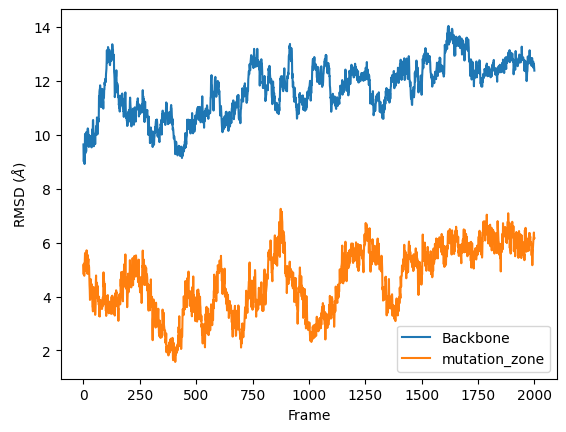

In [6]:
ax = df.plot(x='Frame', y=['Backbone', 'mutation_zone'],
             kind='line')
ax.set_ylabel(r'RMSD ($\AA$)');

De 1-dimensionale RMSD laat zien dat de structuren onstabiele RMSD-waardes hebben, waarvan de mutant rond de 250 en 1000 frames erg fluctueert.

### Pairwise RMSD

In [7]:
wildtype_dismatrix = diffusionmap.DistanceMatrix(wildtype, select="name CA").run()
mutant_dismatrix = diffusionmap.DistanceMatrix(mutant, select="name CA").run()

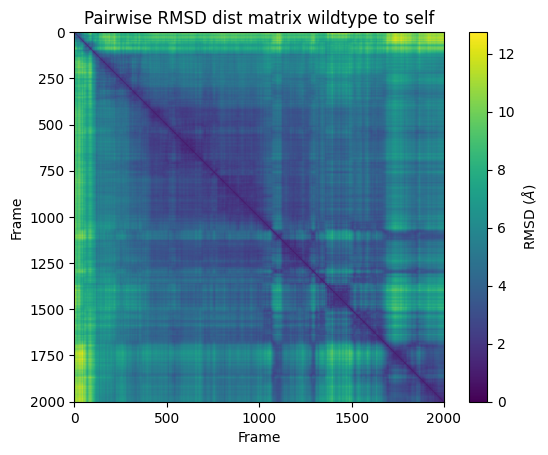

In [8]:
plt.imshow(wildtype_dismatrix.results.dist_matrix, cmap='viridis')
plt.xlabel('Frame')
plt.ylabel('Frame')
plt.colorbar(label=r'RMSD ($\AA$)')
plt.title("Pairwise RMSD dist matrix wildtype to self");

Vanuit de diagonaal is te zien dat het wildtype eiwit een paar keer van structuur veranderd waarvan in het begin frame ~500 tot frame ~1000 een wat grotere formverandering heeft en daarna meerdere kleinere veranderingen ondergaat.

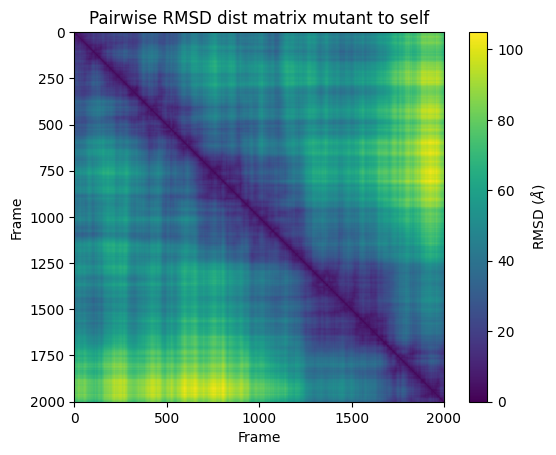

In [15]:
plt.imshow(mutant_dismatrix.dist_matrix, cmap='viridis')
plt.xlabel('Frame')
plt.ylabel('Frame')
plt.colorbar(label=r'RMSD ($\AA$)');
plt.title("Pairwise RMSD dist matrix mutant to self");

De mutant verschilt van het wildtype op 2 manieren. Het meest opvallende is dat de Angstrom-waardes bijna onmogelijk hoog zijn. Het wildtype gaat van 0 tot 12 en de mutant van 0 tot 100. Wat hier precies de oorzaak van is, is onduidelijk. Wel heeft dit als gevolg dat de vormverandering vanuit de diagonaal moeilijker te interpreteren is.  Vanwege de hoge Angstrom-waarde is het moeilijk om met zekerheid te zeggen, maar langs de diagonaal vergeleken met het wildtype lijkt er wel een verschuiving te zijn van de ~500 tot ~1000 frameveranderingen.

In [10]:
# Pairwise RMSD
prmsd = np.zeros((len(wildtype.trajectory),len(mutant.trajectory)))

for i, frame_open in enumerate(wildtype.trajectory):
    r = rms.RMSD(mutant,wildtype, select='name CA',
                 ref_frame=i).run()
    prmsd[i] = r.results.rmsd[:, -1]  # select 3rd column with RMSD values

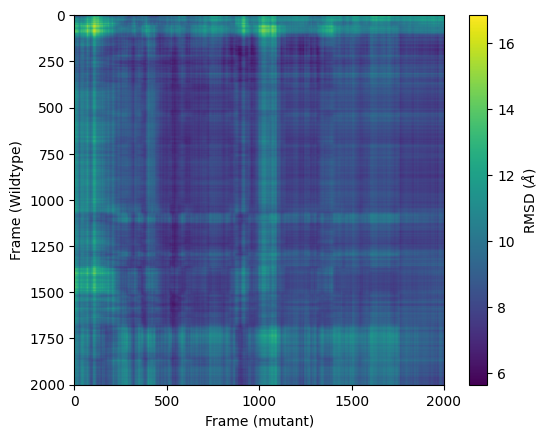

In [11]:
plt.imshow(prmsd, cmap='viridis')
plt.xlabel('Frame (mutant)')
plt.ylabel('Frame (Wildtype)')
plt.colorbar(label=r'RMSD ($\AA$)')

Bij de 2D-vergelijking van het wildtype tegen de mutant geven de blokken met lage RMSD-waardes een vergelijkbare staten en andersom in andere staten. In dit geval komt er veel overeen, behalve op het wildtype 1300 tot 1500 en mutant 0 tot 500 frames en wildtype 0 tot 100 en de mutant 0 tot 100 en 1000 tot 1100 blokken. Ook valt het op dat bij het ~1000-frame van de mutant tegenover het wildtype alle rmsd-waardes hoger liggen dan gemiddeld in de rest van de plot. De 0-tot-eind-hoeken van de mutant en het wildtype tegenover de 0-tot-500-blokken van de mutant en wildtype lijken ook iets verhoogd te zijn tegenover de rest van de plot.

### Ramachandran

In [12]:
#Ramachandran
# mutatie gebied 250-270, mutatie zit op locatie 256

select_wild = wildtype.select_atoms("resid 250-270")
select_mutant = mutant.select_atoms("resid 250-270")

rama_wt = Ramachandran(select_wild).run()
rama_mutant = Ramachandran(select_mutant).run()

Text(0.5, 0.015, 'Ramachandran analyse wildtype op residue 250-270 over 2000 frames')

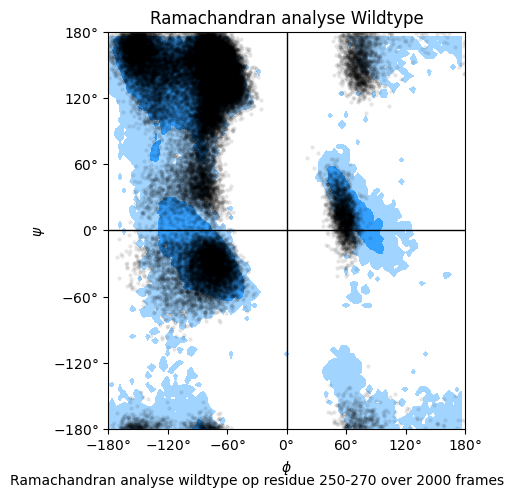

In [13]:
fig, ax = plt.subplots(figsize=plt.figaspect(1))
rama_wt.plot(ax=ax,
             color='k',
             marker='.',
             ref=True,
             alpha=0.1,
             linewidths=0.01)

fig.tight_layout()
ax.set_title("Ramachandran analyse Wildtype")
fig.text(0.5, 0.015, "Ramachandran analyse wildtype op residue 250-270 over 2000 frames",
         horizontalalignment="center")

Text(0.5, 0.015, 'Ramachandran analyse mutant op residue 250-270 over 2000 frames')

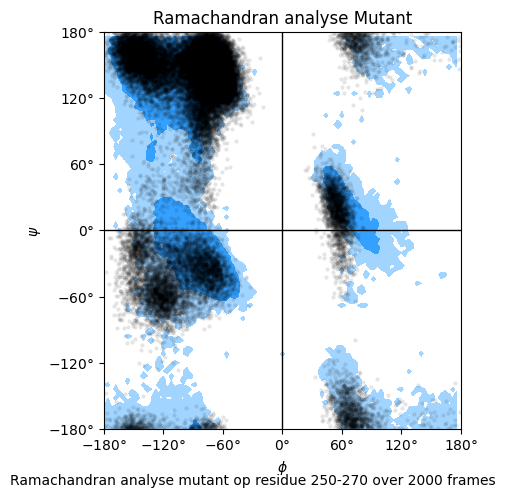

In [14]:
fig, ax = plt.subplots(figsize=plt.figaspect(1))
rama_mutant.plot(ax=ax,
                 color='k',
                 marker='.',
                 ref=True,
                 alpha=0.1,
                 linewidths=0.01)

fig.tight_layout()
ax.set_title("Ramachandran analyse Mutant")
fig.text(0.5, 0.015, "Ramachandran analyse mutant op residue 250-270 over 2000 frames",
         horizontalalignment="center")

De Ramachandran-analyse geeft de phi-backbone en de psi-hoeken, waarbij de blauwe achtergrond de toegestane regio's zijn. Als je de 2 plotjes met elkaar vergelijkt, zie je dat zowel de wildtype- als de mutant punten buiten de toegestane regio hebben, en dat ze onderling ook verschillen in onderste gebieden in zowel expressie als locatie.

## RMSF (Root Mean Square Fluctuation)
Binnen een eiwit bestaan vaak meerdere residues/domeinen en deze hebben elk een eigen flexibiliteit die aangeeft hoe beweeglijk ze zijn. Sommige domeinen zijn meer stug en stabiel en bewegen niet (veel) en andere domeinen kunnen door hun functie juist heel beweeglijk zijn. Deze domeinen kunnen bijvoorbeeld een enzym over laten gaan van een gesloten confirmatie naar een open conformatie of andersom. Om te bepalen wat de flexibiliteit is voor elk van de domeinen, en welk van de domeinen het meest bewegen, kan de RMSF worden bepaald van de posities van de atomen. De RMSF is het tijdsgemiddelde van de RMSD. Het bepalen van de RMSF wordt vaak beperkt tot de backbone/de alpha-carbon atomen, omdat deze een beter beeld geven van de beweeglijkheid, gezien zijketens van zichzelf al flexibeler zijn ([MD Analysis User Guide, z.d.](https://userguide.mdanalysis.org/stable/examples/analysis/alignment_and_rms/rmsf.html)). De RMSF wordt berekend met:


$$
\rho_i = \sqrt{\left\langle \left(x_i - \left\langle x_i \right\rangle \right)^2 \right\rangle}
$$


Om de beweeglijkheid te bepalen, moet een trajectory op een referentie worden gefit. Eerst moet deze referentie worden gemaakt:

In [5]:
def calculate_RMSF(pdb, xtc):
    # Maak 'average structure' (reference), door eerste frame te alignen en gemiddelde te nemen van coordinaten
    u = mda.Universe(pdb, xtc)

    average = align.AverageStructure(u, u, select='protein and name CA',
                                     ref_frame=0).run()
    ref = average.results.universe

    # Bereken RMSF
    c_alphas = u.select_atoms('protein and name CA')
    R = rms.RMSF(c_alphas).run()

    return c_alphas, R, u

c_alphas_wildtype, R_wildtype,_ = calculate_RMSF("wildtype_protein.pdb", "wildtype_protein.xtc")
c_alphas_mutant, R_mutant,_ = calculate_RMSF("mutant_protein.pdb", "mutant_protein.xtc")


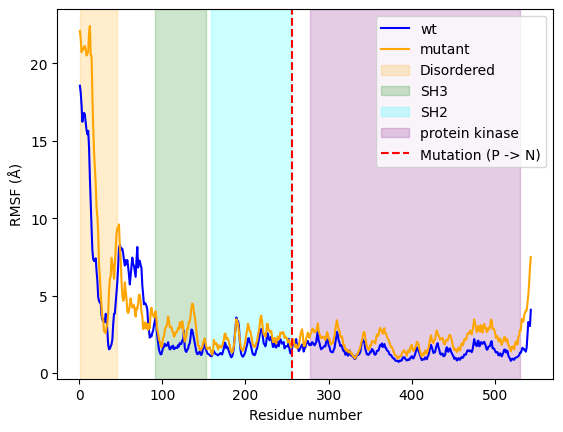

In [74]:
%matplotlib inline

# Plot de RMSF van het wildtype/de mutant
plt.plot(c_alphas_wildtype.resids,
         R_wildtype.results.rmsf,
         color = 'blue',
         label = 'wt'
         )
plt.plot(c_alphas_mutant.resids,
         R_mutant.results.rmsf,
         color = 'orange',
         label = 'mutant'
         )
plt.xlabel('Residue number')
plt.ylabel('RMSF (Å)')
plt.axvspan(1, 45, zorder=0, alpha=0.2, color='orange', label='Disordered')
plt.axvspan(91, 152, zorder=0, alpha=0.2, color='green', label='SH3')
plt.axvspan(158, 255, zorder=0, alpha=0.2, color='cyan', label='SH2')
plt.axvspan(277, 530, zorder=0, alpha=0.2, color='purple', label='protein kinase')

plt.axvline(
    x=256,
    color='red',
    linestyle='--',
    label='Mutation (P -> N)'
)

plt.legend()


In de plot hierboven zien we nu de RMSF van het wildtype en de mutant, gemeten in Angstrom (Å), een lengtemaat gelijk aan $10^{−10}$ meter. De oranje lijn geeft het RMSF aan van de mutant, over alle aminozuren in het eiwit. En de blauwe lijn geeft het wildtype aan. Het YES1 eiwit heeft 3 domeinen:

- SH3 (91-152) (groen)
- SH2 (158-255) (blauw)
- Protein kinase (277-530) (paars)

<img src="imgs/domains.png" width="70%">

Daarnaast is er nog een 'disordered' domein, van locatie 1-45. Hier valt het op dat zowel het wildtype als de mutant een hoge RMSF hebben en lijkt de structuur niet erg stabiel te zijn maar juist erg beweeglijk. De mutatie is aangegeven met een rode stippellijn op locatie 256, net buiten domein SH2.

De RMSF lijkt voor het wildtype redelijk stabiel over de 3 hoofddomeinen, deze blijft tussen de ~2-2.5 Å. Voor de mutant lijkt de RMSF in deze domeinen hoger te liggen dan voor het wildtype en ook lijkt de variantie groter, hier ligt de range tussen de ~2-4.8. Het verschil lijkt aanwezig over de gehele domeinen en niet alleen in specifieke regio's, mogelijk betekent dit dat de algehele beweeglijkheid van de complete domeinen is toegenomen bij de mutant. Opvallend lijkt de vorm van de RMSF nog gelijk, hoewel de RMSF hoger is bij de mutant, volgt het wel dezelfde pieken en dalen als bij het wildtype.

Om makkelijk regio's te kunnen identificeren met hoge beweeglijkheid, kunnen we een b-factor (temperatuur factor) gebruiken. De b-factor kan worden toegevoegd aan een PDB en op deze manier kunnen regio's gekleurd worden aan de hand van hun beweeglijkheid.


In [7]:
def beta_factor(u, R, output):
    u.add_TopologyAttr('tempfactors')
    protein = u.select_atoms('protein')
    for residue, r_value in zip(protein.residues, R.results.rmsf):
        residue.atoms.tempfactors = r_value

    u.atoms.write(output)

_, R_wildtype, u_wildtype = calculate_RMSF("wildtype_protein.pdb", "wildtype_protein.xtc")
_, R_mutant, u_mutant = calculate_RMSF("mutant_protein.pdb", "mutant_protein.xtc")
beta_factor(u_wildtype, R_wildtype, "wildtype_rmsf.pdb")
beta_factor(u_wildtype, R_wildtype, "mutant_rmsf.pdb")

Met het PyMOL script `visualizeRMSF` kunnen mutant en wildtype worden bekeken en beweeglijke regio's worden geïdentificeerd. Hieronder zijn wildtype en mutant op elkaar ge-aligned en is de RMSF met kleuren aangegeven, waarbij blauw een lage RMSF is (lage beweeglijkheid), wit een 'middelmatige' RMSF en rood een hoge RMSF (hoge beweeglijkheid). Het valt op dat voor beide varianten dezelfde plekken een middel-tot hoge RMSF hebben, namelijk in de lange loop die langs het eiwit loopt. Vanaf ongeveer residu 1-30 eb 45-79 is de beweeglijkheid middelmatig tot hoog. De regio van 1-30 valt binnen het disordered 'domein', dus is een hoge RMSF te verwachten. 45-79 ligt niet binnen een domein. Alle gedeelten binnen de 3 daadwerkelijke domeinen (SH2, SH3, protein kinase) zijn blauw gekleurd en zijn dus best stabiel.

<img src="imgs/rmsf_wt_mutant.png" width="50%">

<img src="imgs/compare_rmsf.gif" width="50%">

# Secundaire structuren

Nu gaan we de secundaire structuren van het wildtype en de mutant vergelijken. Eerst doen we dit op basis van de PDB, de PDB van het wildtype is gemaakt met: `gmx trjconv -s wildtype_protein.tpr -f ../wats-w/wildtype.xtc -pbc mol -o ../wildtype/wildtype_protein.pdb -dump 0`. De PDB van de mutant is op dezelfde manier gemaakt, maar dan met de tpr en xtc van de mutant. De PDB bestaat dus uit de eerste frame van de run. Vervolgens kunnen we deze PDB's omzetten in universe objecten en hieruit de secundaire structuren voorspellen. We selecteren hierbij residue 1-542, omdat het laatste residu geen peptidebinding aangaat, waardoor de COOH-groep blijft behouden. Deze worden dan onjuist genoteerd als CO1 en CO2, wat niet goed werkt met MDAnalysis.

In [3]:
# bepaal secundaire structuur op basis van de eerste frame
def secondaryPDB(pdb):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        u = mda.Universe(pdb).select_atoms('resid 1-542')
        secondary_structure = ''.join(DSSP(u).run().results.dssp[0]) + '-'
    return secondary_structure

secondary_PDB_structure_mutant = secondaryPDB("mutant_protein.pdb")
secondary_PDB_structure_wildtype = secondaryPDB("wildtype_protein.pdb")

print("____________Secondary Structure Wildtype PDB__________")
print(secondary_PDB_structure_wildtype)
print(f"N. of Es:{secondary_PDB_structure_wildtype.count("E")}")
print(f"N. of Hs:{secondary_PDB_structure_wildtype.count("H")}")
print(f"N. of -s:{secondary_PDB_structure_wildtype.count("-")}")


print("____________Secondary Structure Mutant PDB__________")
print(secondary_PDB_structure_mutant)
print(f"N. of Es:{secondary_PDB_structure_mutant.count("E")}")
print(f"N. of Hs:{secondary_PDB_structure_mutant.count("H")}")
print(f"N. of -s:{secondary_PDB_structure_mutant.count("-")}")

____________Secondary Structure Wildtype PDB__________
------------------------------------E----------------------------------------------------------EEE---E------E--E----EEEE-E-----EEEEEE----EEEEEEHHHEEE---HHH---E-------HHHHHHH-------EEEEEE-------EEEEEEEEE---EEEEEEEEEEE-----EE-----EE--HHHHHHHH----E-E-----EE----------------E--HHHEEE-EE-EE----EEEEEEE---EEEEEEE-------HHHHHHHHHHHHH-----E--E-EEE-----EEEE-----EEHHHHHHH--HHH--HHHHHHHHHHHHHHHHHHHHH-EE-----HHHEEE-HHH-EEE------EE-E--EEE------E-HHH--HHHHHH-EE-HHHHHHHHHHHHHHHH-----------HHHHHHHHH------------HHHHHHHHH-----HHH---HHHHHHHHH----------------
N. of Es:112
N. of Hs:129
N. of -s:302
____________Secondary Structure Mutant PDB__________
-----------------------------------------------------------------------------------------------EEE---E------E--E----EEEE-E-----EEEEEE-----EEEEEHHHEEE---HHH---E-------HHHHHHH-------EEEEEE-------EEEEEEEEE---EEEEEEEEEEE-----EE-E--EEE--HHHHHHHH------------EE----------------E--HHHEEE-EE-EE---EEEEEEEE---EEEEEEEE--

C:\Users\Yami\AppData\Local\Programs\Python\Python314\Lib\site-packages\MDAnalysis\analysis\base.py:562: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[idx] = ts.time


Hierboven zie je de secundaire structuren van wildtype/mutant, op basis van de PDB (eerste frame van de run). Er zijn 3 verschillende soorten tekens te zien, `E` (sheet), `H` (helix) en `-` (loop). Er zijn gelijk al een aantal verschillen te zien tussen wildtype en mutant, zo lijken een aantal E's bij het wildtype niet aanwezig te zijn bij de mutant, en andersom. Hetzelfde geldt voor de H's. Het totaal aan E's en H's lijkt dan ook te verschillen onderling. 112 E's bij wildtype en 109 bij mutant en 129 H's bij wildtype en 126 bij mutant. Het aantal loops lijkt toegenomen te zijn bij de mutant ten opzichte van het wildtype.

Gezien dit alleen laat zien hoe de secundaire structuren eruit zien tijdens de eerste frame, is het ook goed om verder te kijken naar de rest van de frames. Dat doen wij hieronder. Voor elke `residue` (aminozuur) wordt gekeken naar wat de gemiddelde secundaire structuur hiervan is binnen het eiwit. Dat wil zeggen dat als van alle frames, het residu het vaakste onderdeel was van een helixstructuur, dat het dan een `H` krijgt toegewezen.

In [4]:
# bepaal gemiddelde secundaire structuur van alle residues
def secondaryTPR(tpr, xtc):
    u = mda.Universe(tpr, xtc).select_atoms('resid 1-542')
    long_run = DSSP(u).run()
    mean_secondary_structure = translate(long_run.results.dssp_ndarray.mean(axis=0))
    structure = ''.join(mean_secondary_structure)
    print(structure)
    print(f"N. of Es:{structure.count("E")}")
    print(f"N. of Hs:{structure.count("H")}")
    print(f"N. of -s:{structure.count("-")}")

print("____________Secondary Structure Wildtype PDB__________")
secondaryTPR("wildtype_protein.tpr", "wildtype_protein.xtc")
print("____________Secondary Structure Mutant PDB__________")
secondaryTPR("mutant_protein.tpr", "mutant_protein.xtc")

____________Secondary Structure Wildtype PDB__________
------------------------------------E---------------------------------------------------------EEEE---E------E--E----EEEE-E-----EEEEEE-----EEEEEHHHEEE---HHH---E-----HHHHHHHH---------EEEEE-------EEEEEEEEE---EEEEEEEEEEE-----EE-----EE--HHHHHHHH-------------E----------------E--HHHEEE-EE-EE---EEEEEEEE---EEEEEEEE------HHHH-HHHHHH-------E--E-EEE-----EEEE-----EEHHHHHH--HHHH--HHHHHHHHHHHHHHHHHHHH--EE-----HHHEEE-HHH-EEE------EE-----EE------E------HHHHH--EE-HHHHHHHHHHHHHHHH-----------HHHHHHHHH------------HHHHHHHHHH----------HHHHHHHH----------------
N. of Es:108
N. of Hs:119
N. of -s:315
____________Secondary Structure Mutant PDB__________
---------------------------------------------------------------HHH-----------------------------EEE---E------E--E----EEEE-E-----EEEEEE-----EEEEEHHHEEE---HHH---E-------HHHHHH---------EEEEE-------EEEEEEEEE---EEEEEEEEEEE-----EE-----EE--HHHHHHHH-------------E----------------E--HHHEEE-EE-EE---EEEEEEEE---EEEEEEEE---

Ook hier zijn er weer verschillen te zien in aantallen en locaties van `E`, `H` en `-`. Al lijken deze niet zo extreem groot, als je nagaat hoeveel frames er zijn en dat er in de aantallen slechts een klein verschil zit. Toch kunnen deze kleine verschillen een grote impact hebben op de ruimtelijke structuur en stabiliteit van het eiwit.

# PCA en Mean trajectory

## Wildtype

<img src="imgs/pymol_ray_2.png" width="60%">

Hierboven staat een visualisatie van het wildtype YES1-eiwit, waarbij de blauwrode lijnen de richting van de trajectory van begin naar eind visualiseren. wat hier te zien is, is dat de kern van het eiwit een stabiele beweging heeft, maar dat de loops aan de zijkant van het eiwit verplaatsen naar het eiwit toe en dat het een vrij lange beweging maakt langs het eiwit.



<img src="imgs/wildtype_dynamics.gif" width="60%">


<img src="imgs/pymol_select_reg_mean_v_normal3.png" width="60%">


Nogmaals dezelfde PCA op het wildtype, maar dan vanuit een andere hoek, gecentreerd op het mutatiegedeelte dat cyaan gekleurd is. Dit gedeelte zit tussen het SH2- en het proteïnekinasedomein. Zoals te zien hierboven heeft dit een korte beweging die in lijn is met de rest van het eiwit.

<img src="imgs/pymol_select_reg_mean_v_normal.png" width="60%">

Hierboven is een visualisatie van het wildtype-eiwit naast het gemiddelde van de PCA, gecentreerd op het gebied van YES1. Hierin is de blauw-groene keten van het eiwit en de oranje-groene keten geeft de plek van het gemiddelde weer. Zoals te zien is in het geval van het wildtype ligt deze niet ver van het startpunt af en houdt het dezelfde formatie aan totdat het naar het blauwgekleurde domein loopt, waar het wel dezelfde vorm behoudt, maar verder van de startpositie afligt.

<img src="imgs/pymol_select_reg_mean_v_normal2.png" width="60%">

Andere hoek van het gemiddelde tegenover het eiwit.

<img src="imgs/pymol_select_reg_mean_v_pca.png" width="60%">

Hierboven staat de visualisatie van de PCA van het wildtype als blauwrode lijnen en de ketens het gemiddelde, gecentreerd op het gebied waar de mutatie kan plaatsvinden. Zoals te zien is, lopen de lijnen consistent met het gemiddelde.

<img src="imgs/pymol_select_reg.png" width="60%">

Andere hoek van de pca v gemiddelde visualisatie.

## Mutant

We visualiseren nu weer het minimum/maximum trajectory, maar dan van de mutant



<img src="imgs/mutant_dynamics.gif" width="60%">


<img src="imgs/mutation_dynamics.png" width="60%">


Hierboven is een ingezoomde versie te zien, waarin de locatie van de mutatie en omliggende residuen goed te zien zijn. Het aminozuur dat met zijn zijketen het meeste naar boven uitsteekt is het gemuteerde aminozuur (proline -> asparagine). En hieronder is de versie van het wildtype te zien. De lijnen lijken bij het wildtype meer recht omhoog te gaan, dan bij de mutant. De bewegingsrichting van het eiwit lijkt dan ook aangetast.


<img src="imgs/wildtype_dynamics.png" width="60%">


# Eindconclusie wildtype vs variant

We hebben wildtype en mutant nu vergeleken op verschillende manieren, we geven nu een korte conclusie per methode:

## RMSD:
De verschillen in de pairwise MSD-plots laten een verschil in patroon zien in het geval waar het wildtype en de mutant tegen zichzelf zijn geplot, en bij de pairwise-analyse tegen elkaar valt het op dat bij frame ~1000 van de mutant er een groter verschil in RMSD-waardes is. Dit kan betekenen dat de mutant in dat stadium van beweging verstoord is.

## Ramachandran:
De Ramachandran laat zien dat er verschil is in de phi-backbone en de psi-hoeken in de mutant ten opzichte van het wildtype, die voornamelijk in de -60° tot -90°-regio veranderd zijn. Aangezien het mutatiegebied tussen 2 domeinen ligt, zou het verschil in de backbone- en psi-hoeken een verklaring kunnen zijn voor de verandering in gedrag van het eiwit.

## RMSF:
Zoals te zien is, bevindt de mutatie zich in een loop die het proteïne-kinase- en SH2-domein linkt. Als de mutatie de interactie tussen deze 2 domeinen flexibeler maakt, kan het ertoe leiden dat er een meer open structuur van het proteïne-kinase-domein ontstaat, wat weer kan leiden tot overmatige activiteit van het YES1-eiwit.

## Secundaire structuren:
De secundaire structuren lijken lichtelijk aangetast in de gemuteerde variant, er komen bij de mutant gemiddeld meer loops en helices voor en minder sheets vergeleken met het wildtype. De verschillen lijken niet heel groot, maar kunnen alsnog een grote impact hebben op de ruimtelijke structuur en daarmee de stabiliteit/activiteit van het eiwit veranderen.


Uit deze analyse zijn er op meerdere onderdelen verschillen gevonden in de vorm en beweging van het gemuteerde eiwit ten opzichte van het wildtype. De carcinogeniteit van de mutatie ligt mogelijk in de veranderde beweging/compositie van het eiwit, wat kan leiden tot een overmatige activiteit van het YES1-eiwit, met als gevolg ongecontroleerde celgroei. Om de aard van de activiteit van het gemuteerde eiwit nog verder te kunnen bekijken, zouden aanvullende analyses uitgevoerd kunnen worden, zoals die binnen de proteomics.

# Bronnen
- The Amber Project. (z.d.). The Amber Force fields. https://ambermd.org/AmberModels_proteins.php
- MD Analysis User Guide. (z.d.). Calculating the root mean square fluctuation over a trajectory. https://userguide.mdanalysis.org/stable/examples/analysis/alignment_and_rms/rmsf.html
- Zhu, Z. (2020, 26 april). Introduction to Gromacs. EigenBlog. https://naturegeorge.github.io/eigenblog/posts/gmx/
- gmx pdb2gmx — GROMACS 5.1 documentation. (z.d.). https://manual.gromacs.org/documentation/5.1/onlinehelp/gmx-pdb2gmx.html
- Kook, E., Chun, K., & Kim, D. (2024). Emerging Roles of YES1 in Cancer: The Putative Target in Drug Resistance. _International Journal Of Molecular Sciences_, _25_(3), 1450. https://doi.org/10.3390/ijms25031450
- Embl-Ebi. (z.d.). _pLDDT: Understanding local confidence | AlphaFold_. https://www.ebi.ac.uk/training/online/courses/alphafold/inputs-and-outputs/evaluating-alphafolds-predicted-structures-using-confidence-scores/plddt-understanding-local-confidence/
- Zhou, H., Sun, D., Tao, J., Xu, M., Zhang, X., & Hou, H. (2023). Role of YES1 signaling in tumor therapy resistance. Cancer Innovation, 2(3), 210–218. https://doi.org/10.1002/cai2.51
- UniProt. (z.d.). https://www.uniprot.org/uniprotkb/P07947/entry
- GROMACS. (z.d.-b). Topologies. https://manual.gromacs.org/documentation/current/reference-manual/topologies/topologies.html
- Wikipedia contributors. (2025, 18 november). Water model. Wikipedia. https://en.wikipedia.org/wiki/Water_model#3-site
- Hamanaka, N., Nakanishi, Y., Mizuno, T., Horiguchi-Takei, K., Akiyama, N., Tanimura, H., Hasegawa, M., Satoh, Y., Tachibana, Y., Fujii, T., Sakata, K., Ogasawara, K., Ebiike, H., Koyano, H., Sato, H., Ishii, N., & Mio, T. (2019). YES1 Is a Targetable Oncogene in Cancers Harboring YES1 Gene Amplification. Cancer Research, 79(22), 5734–5745. https://doi.org/10.1158/0008-5472.can-18-3376

***

&copy; 2025 - Yamila Timmer, Ivar Lottman